In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')
import os

In this notebook we test the performance of a second LSTM model different from the one with which we worked on the previous notebook. The preparation of the data is quite similar, for that reason we'll skip some steps in order to avoid repetition.

# 3.2.1 Loading Data

In [2]:
full = pd.read_csv('./data/clean/full_data.csv', parse_dates = True, index_col = 0)
elec = pd.DataFrame(full.pop('electricity'))
full = full.join(elec) 

# 3.2.3 Data preprocesing

Now we frame one more time the problem as a supervised learning problem adding columns for values for the previous hours and keeping the target columns as the current hour. The model will learn to predict the next 6 hours of energy consumption being given the previous N = 24 hours of meteorological data as well as previous electric load.

In [3]:
 # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #df = pd.DataFrame(data)
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(j)) for j in data.columns]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def weather_supervised(dataframe, n_in, n_out):
    df = dataframe.copy()
    df.pop('electricity')
    return series_to_supervised(data = df, n_in = n_in, n_out = n_out, dropnan=True)

def electric_supervised(dataframe, n_in, n_out):
    elec = pd.DataFrame(dataframe['electricity'])
    elec_sup = series_to_supervised(data = elec, n_in = n_in, n_out = n_out, dropnan=True)
    return elec_sup

In [5]:
electricity = electric_supervised(full, 24, 6)
weather = weather_supervised(full, 24, 6)
full = weather.iloc[:,:-6*9].join(electricity)

In [6]:
full.columns

Index(['air_temperature(t-24)', 'dew_temperature(t-24)',
       'sea_level_pressure(t-24)', 'wind_direction(t-24)', 'wind_speed(t-24)',
       'month(t-24)', 'day(t-24)', 'weekday(t-24)', 'hour(t-24)',
       'air_temperature(t-23)',
       ...
       'electricity(t-4)', 'electricity(t-3)', 'electricity(t-2)',
       'electricity(t-1)', 'electricity(t)', 'electricity(t+1)',
       'electricity(t+2)', 'electricity(t+3)', 'electricity(t+4)',
       'electricity(t+5)'],
      dtype='object', length=246)

Separate data from labels

In [7]:
X = full.iloc[:,:-6]
y = full.iloc[:,-6:]

In [8]:
X.shape, y.shape

((26275, 240), (26275, 6))

Building scalers and normalizing

In [9]:
mm = MinMaxScaler()
ss = StandardScaler()
X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

Spliting dataset into training and testing sets

In [10]:
#We split the data into 2/3 of the time for training and 1/3 for testing 
#which would lead to 2 years for training and one year fo testing
train_hours = int(2*full.shape[0]/3)

X_train = X_ss[:train_hours, :]
X_test = X_ss[train_hours:, :]
y_train = y_mm[:train_hours, :]
y_test = y_mm[train_hours:, :]

#to tensors and variables
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

Reshaping input data with the sequential infromation (number of considered rows)

In [11]:
#reshaping to rows, timestamps, features
seq = 1
X_train_tensors_final = torch.reshape(X_train_tensors,   (int(X_train_tensors.shape[0]/seq), seq, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (int(X_test_tensors.shape[0]/seq), seq, X_test_tensors.shape[1])) 

In [12]:
X_train_tensors_final.shape

torch.Size([17516, 1, 240])

# 3.2.4 Building the model

In [13]:
class LSTM_E_2(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, num_dir, device):
        super(LSTM_E_2, self).__init__()

        self.device = device
        self.num_classes = num_classes #number of outputs
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.num_directions = num_dir

        if num_dir == 2:
            bi = True
        else: 
            bi = False

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional = bi ) #lstm
        self.fc_1 =  nn.Linear(hidden_size*num_dir, 300) #fully connected 1
        self.fc = nn.Linear(300, num_classes) #fully connected last layer

        self.relu = nn.ReLU() 

    def forward(self,x):
        h_0 = Variable(torch.zeros(
              self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device) #hidden state
        c_0 = Variable(torch.zeros(
            self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device) #internal state

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #print(output.shape)
        out = output.view(-1, self.hidden_size*self.num_directions) #reshaping the data for Dense layer next
        #print(out.shape)
        out = self.relu(out)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        #print(out.shape)
        
        return out 

Create or load model

In [14]:
#checking if there are any saved model checkpoint
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
if os.path.isfile('./data/models/model_2_checkpoint.tar'):
    #load the model
    model = LSTM_E_2(num_classes = 6, input_size = X_train_tensors_final.shape[2], hidden_size=133, num_layers=1, seq_length=X_train_tensors_final.shape[1],  num_dir = 1, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    # Make sure to call input = input.to(device) on any input tensors that you feed to the model

    checkpoint = torch.load('./data/models/model_2_checkpoint.tar', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(model)
    
else:
    model = LSTM_E_2(num_classes = 6, input_size = X_train_tensors_final.shape[2], hidden_size=133, num_layers=1, seq_length=X_train_tensors_final.shape[1],  num_dir = 1, device=device)
    model.to(device)
    print(model)


LSTM_E_2(
  (lstm): LSTM(240, 133, batch_first=True)
  (fc_1): Linear(in_features=133, out_features=300, bias=True)
  (fc): Linear(in_features=300, out_features=6, bias=True)
  (relu): ReLU()
)


Determinig loss criterion, optimizer, num_epochs and learning_rate

In [15]:
learning_rate = 0.001 #0.001 lr
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
num_epochs = 700 

Epoch: 0, loss: 0.13896, val_loss: 0.13523
Epoch: 50, loss: 0.00254, val_loss: 0.00263
Epoch: 100, loss: 0.00173, val_loss: 0.00221
Epoch: 150, loss: 0.00144, val_loss: 0.00209
Epoch: 200, loss: 0.00124, val_loss: 0.00201
Epoch: 250, loss: 0.00107, val_loss: 0.00197
Epoch: 300, loss: 0.00094, val_loss: 0.00192
Epoch: 350, loss: 0.00084, val_loss: 0.00190
Epoch: 400, loss: 0.00077, val_loss: 0.00190
Epoch: 450, loss: 0.00072, val_loss: 0.00192
Epoch: 500, loss: 0.00066, val_loss: 0.00195
Epoch: 550, loss: 0.00062, val_loss: 0.00201
Epoch: 600, loss: 0.00058, val_loss: 0.00205
Epoch: 650, loss: 0.00055, val_loss: 0.00208


Text(0, 0.5, 'MSE loss')

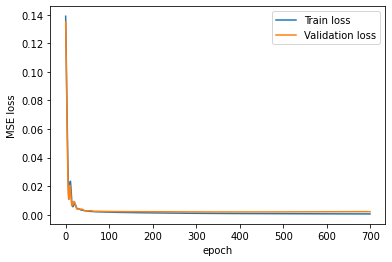

In [19]:
#train 1
model.train()

train_loss = []
val_loss = []
X_test_tensors_final = X_test_tensors_final.to(device)
y_test_tensors = y_test_tensors.to(device)
X_train_tensors_final = X_train_tensors_final.to(device)
y_train_tensors = y_train_tensors.to(device)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
    # obtain the batch loss 
    loss = criterion(outputs, y_train_tensors)
    train_loss.append(loss.item())
    loss.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backpropagation

    #validation
    val_out = model.forward(X_test_tensors_final)
    loss_val =criterion(val_out, y_test_tensors)
    val_loss.append(loss_val.item())

    if epoch % 50 == 0:
    print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, train_loss[epoch], val_loss[epoch])) 

epoch = np.arange(0,num_epochs)

#plotting
plt.plot(epoch, train_loss, label = "Train loss")
plt.plot(epoch, val_loss, label = "Validation loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [20]:
#to save model you'll have to train/keep training the model
torch.save({
            'epoch': len(epoch),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            }, './data/models/model_1_checkpoint.tar')

# 3.2.5 Validating model

Normalizing

In [16]:
df_X_ss = ss.transform(full.iloc[:,:-6]) #old transformers
df_y_mm = mm.transform(full.iloc[:,-6:]) #old transformers
df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

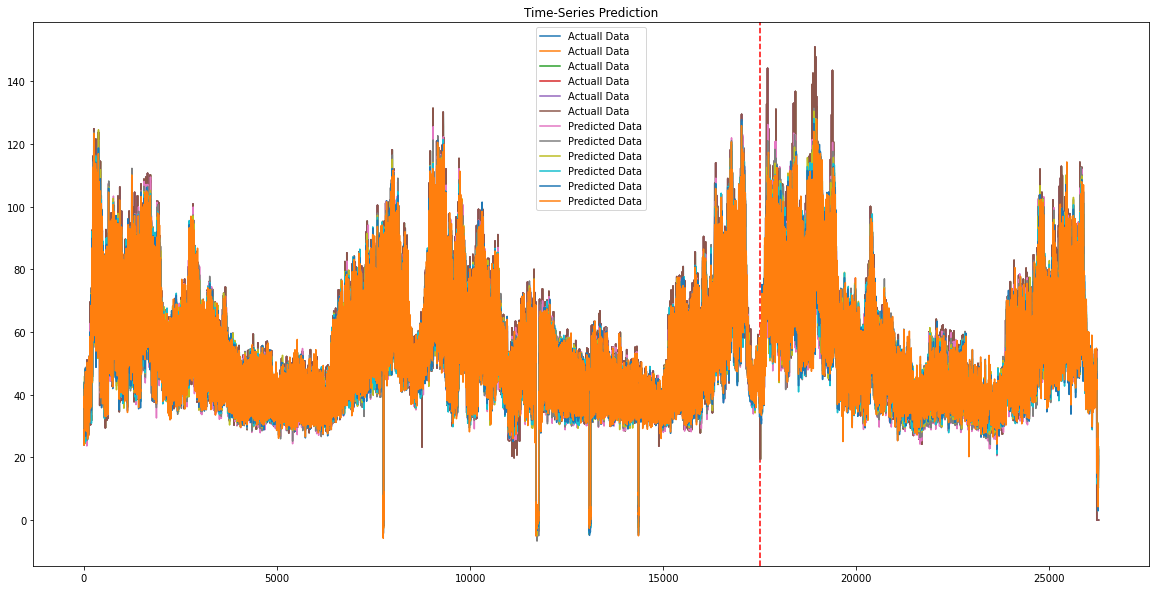

Test RMSE: 4.893


In [17]:
model.eval()

train_predict = model(df_X_ss.to(device))#forward pass
data_predict = train_predict.cpu().data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10)) #plotting
plt.axvline(x=train_hours, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

rmse = np.sqrt(mean_squared_error(dataY_plot, data_predict ))
print('Test RMSE: %.3f' % rmse)

To the left of the dashed vertical line we have the training data and to the right the testing data. We see that the actual yearly trend seems to have been correctly fitted in the validation set. Here we have represented each of the 6 calculated values (for every hour avead) for each inout vector. 

We'll zoom in in the third year of the data set and compare the actual values vs. the forecasted ones to see how it fits monthly, weekly and daily fluctuations. 
We'll just use the first of te 6 calculated values based on the idea that the NN should learn the trend and fit a curve in those 30 points (24 before the current value, the current value, and 5 afterwards) being the fit closer to the actual value for the points that come earlier in the prediction curve. 

We see that the squared root of the MSE on the total data set is of 4.893, which is greater than in the previous model, but we should take into account that this model works not only one but six target values.

In [27]:
Predicted = go.Scatter(x=y[train_hours:].index, y=data_predict[train_hours:,0].flatten(), opacity = 1, name = 'Forecasted Value (1)', line=dict(color='violet'), yaxis='y')
Actual = go.Scatter(x=y[train_hours:].index, y=y['electricity(t)'][train_hours:].values, opacity = 0.7, name = 'Actual Value', line=dict(color='royalBlue'), yaxis='y')
layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Predicted, Actual], layout=layout)
fig.show() # if this is rendered in colab, you should run fig.show(renderer='colab') instead.

At first sight it seems that the model is not as good as the previous one at aproximating correctly the highest peaks of power load. However, there are some regions, namely between April and May, where the overestimation got reduced as well as the underestimation. At large scale, the overall performance of the twoo models seems to be similar. As the previous model, this one also captured the daily trends as well as the average.

As thought, using the first forecasted hour to compare predicted and actual values, get a better fit of the patterns. In the following graph we see the fit using the last fitted value (the sixth hour ahead).

In [19]:
Predicted = go.Scatter(x=y[train_hours:].index, y=data_predict[train_hours:,5].flatten(), opacity = 1, name = 'Forecasted Value (6)', line=dict(color='pink'), yaxis='y')
Actual = go.Scatter(x=y[train_hours:].index, y=y['electricity(t)'][train_hours:].values, opacity = 0.7, name = 'Actual Value', line=dict(color='royalBlue'), yaxis='y')
layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Predicted, Actual], layout=layout)
fig.show() # if this is rendered in colab, you should run fig.show(renderer='colab') instead.

As with the previous model, this validation feeds the model always with the actual previous values (weather and electricity) without taking into account the forecasted value as part of the previous electricity load information. That would signify that this plot shows how the model performs strictly in the frame of the specified problem (forecast six hours ahead with 24 previous ACTUAL values). 

That being said, if we compare the two models with the task of predicting one hour ahead (the frame for the first model), the first model seems to outperform the second. 

## Load forecast using predicted values as input values

Once the model has been trained, we'll define a function to predict the energy consumption N hours ahead the last inputed data. 
We'd expect that the error of the forecast value sums up causing the forecast values to drift away from the actual values but in a smaller amount than in the previous model based on the arguments that were stated before.

In [20]:
full = pd.read_csv('./data/clean/full_data.csv', parse_dates = True, index_col = 0)
elec = pd.DataFrame(full.pop('electricity'))
full = full.join(elec) 

In [21]:
prev_fut = full.iloc[-1596:-1476,:] #amount of hours equivalent to 5 days

In [22]:
def daily_consumption_forecast_1(previous_df):
    '''
    Takes previous day weather and electrical load information and predicts next day load profile
    '''
    actual_val = pd.DataFrame(data = previous_df.values, columns = previous_df.columns, index = previous_df.index)
    y_predic = []
    for i in range(previous_df.shape[0]-30):
        #filter out from data frame the 12+1 values which will be used
        #to generate the input tensor. This includes the last predicted value.
        previous = previous_df.iloc[i:i + 30,:]
        #prepare and generate input array
        electricity = electric_supervised(previous, 24, 6)
        weather = weather_supervised(previous, 24, 6)
        in_previous = weather.iloc[:,:-6*9].join(electricity)
        # select inputs and targets
        X_previous = in_previous.iloc[:,:-6]
        y_previous = in_previous.iloc[:,-6:]
        #normalization
        X_val = ss.transform(X_previous)
        y_val = mm.transform(y_previous) 
        #from array to tensors and variables
        X_val_tensors = Variable(torch.Tensor(X_val))
        y_val_tensors = Variable(torch.Tensor(y_val))
        #reshape input tensor
        seq = 1
        X_val_tensors_final = torch.reshape(X_val_tensors,   (int(X_val_tensors.shape[0]/seq), seq, X_val_tensors.shape[1]))
        #forward pass
        model.eval()
        y_pred = model.forward(X_val_tensors_final.to(device))
        #reverse normalization
        y_predict = y_pred.cpu().data.numpy() #numpy conversion
        y_predict = mm.inverse_transform(y_predict)
        #add to dataframe the calculated value for the next hour
        aux = previous['electricity'].values.tolist()
        aux[24] = y_predict.item(0) #we select only the first predicted value
        y_predic.append(y_predict.item(0))
        previous_df.iloc[i:i + 30,:]['electricity'] = aux

    prediction = pd.DataFrame(data = previous_df.values, columns = previous_df.columns, index = previous_df.index)

    return prediction, actual_val, y_predic

In [23]:
pd.options.mode.chained_assignment = None
pred,act, y_f = daily_consumption_forecast_1(prev_fut)

In [24]:
Predicted = go.Scatter(x=act.iloc[24:,:].index, y=np.array(y_f), opacity = 1, name = 'Forecasted Value', line=dict(color='orange'), yaxis='y')
Actual = go.Scatter(x=act.index, y=act['electricity'].values, opacity = 0.7, name = 'Actual Value', line=dict(color='royalBlue'), yaxis='y')
layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Predicted, Actual], layout=layout)
fig.show() # if this is rendered in colab, you should run fig.show(renderer='colab') instead.

We observe that the model tends to overestimate and underestimate in the first day (behaviour that we already observed). However, with the passing of the days, the forecasting outperforms the previous model in the way that the forcasted and actual curve stay closer with the passing of the days, fact that did not occur in the first model.

In the graph below we show the equivalent graph of the first model.
![1rst Model Performance](./data/images/model1_performance.png)

In the next model we'll try a fully conected NN to compare the behaviour with this two LSTM-based models and see if with the framing with which we've been woking, LSTM make a substantial difference.

-----